In [11]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_COLOR_DESAT = '#D98C90'
CR_COLOR_DESAT = '#A0A0A0'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']


BS_animal_M2 = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']
animals = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']

act_directory = 'D:\\Analysis_Cache'
ops_directory = 'D:\\Opsin_Cache'
beh_directory = 'Z:\\Behavioor'

stdfont = 14
stdyfrac = 0.06

M2_FRmod_baseline_median = 2.3
AC_FRmod_baseline_median = 3.5

In [12]:
import pandas as pd
from pathlib import Path
import numpy as np
import os
import matplotlib.pyplot as plt
import dlc2kinematics

In [13]:
dataname1 = 'C:\\Users\insan\\Desktop\\Motion project training\\308_2024-04-26_11-40-26\\308_2024-04-26_11-40-26DLC_resnet50_Training_projectApr9shuffle1_500000.h5'
dataskeleton1 = 'C:\\Users\insan\\Desktop\\Motion project training\\308_2024-04-26_11-40-26\\308_2024-04-26_11-40-26DLC_resnet50_Training_projectApr9shuffle1_500000_skeleton.h5'

dataframe1 = pd.read_hdf(os.path.join(dataname1))
dataskeleton1 = pd.read_hdf(os.path.join(dataskeleton1))
likelihood_thres = 0.9

In [14]:
dataframe1

scorer    DLC_resnet50_Training_projectApr9shuffle1_500000              \
bodyparts                                          Pupilup               
coords                                                   x           y   
0                                               305.411407  105.067261   
1                                               305.256683  105.416000   
2                                               305.067871  104.932190   
3                                               304.515717  105.476181   
4                                               302.595856  106.673859   
...                                                    ...         ...   
96943                                           301.302643  117.918549   
96944                                           301.398682  118.137581   
96945                                           301.633392  118.219704   
96946                                           300.872650  118.787155   
96947                                           300.667084  119.466339   

scorer                                                               \
bodyparts              Pupildown                          Pupilleft   
coords    likelihood           x           y likelihood           x   
0           0.999999  319.001526  176.475372   0.991471  262.424103   
1           1.000000  318.981293  176.800888   0.984431  262.943085   
2           1.000000  318.820923  176.126236   0.987745  262.908600   
3           1.000000  318.699005  175.834930   0.976221  262.793762   
4           1.000000  319.431671  176.675217   0.974394  263.102783   
...              ...         ...         ...        ...         ...   
96943       1.000000  316.557037  167.540649   0.999999  280.915405   
96944       1.000000  316.456879  167.265472   0.999999  280.913757   
96945       1.000000  316.518311  167.268799   0.999999  281.029297   
96946       1.000000  316.151703  166.630219   0.999999  281.190918   
96947       1.000000  316.385223  166.920517   0.999999  281.369110   

scorer                                        ...                         \
bodyparts                         Pupilright  ...   Eyelidup  Eyeliddown   
coords              y likelihood           x  ... likelihood           x   
0          150.409958        1.0  348.277802  ...   0.999963  317.913696   
1          150.637619        1.0  348.512878  ...   0.999963  317.875000   
2          150.399841        1.0  348.227142  ...   0.999967  317.591919   
3          151.248535        1.0  348.625916  ...   0.999984  318.273407   
4          152.646851        1.0  348.685760  ...   0.999992  318.010345   
...               ...        ...         ...  ...        ...         ...   
96943      154.048355        1.0  335.331604  ...   0.999995  319.701233   
96944      153.795395        1.0  335.047363  ...   0.999995  319.009979   
96945      153.727249        1.0  335.147766  ...   0.999995  319.013977   
96946      154.090805        1.0  334.543152  ...   0.999995  318.941833   
96947      154.634644        1.0  334.489960  ...   0.999994  318.968262   

scorer                                                               \
bodyparts                         Eyelidleft                          
coords              y likelihood           x           y likelihood   
0          187.483231   1.000000  245.120743  166.487976        1.0   
1          187.808014   1.000000  245.565186  166.899170        1.0   
2          187.276672   1.000000  245.357315  166.770248        1.0   
3          186.847656   0.999999  245.920868  166.998230        1.0   
4          186.918274   1.000000  245.944092  166.632263        1.0   
...               ...        ...         ...         ...        ...   
96943      177.925339   1.000000  244.483414  160.050110        1.0   
96944      177.361420   1.000000  244.379654  159.772736        1.0   
96945      177.364120   1.000000  244.382126  159.654282        1.0   
96946      177.228958   1.000000  244.837646  159.4

In [15]:
def cal_pupildiameter(dlc_pupileye,dlc_pupileyeskeleton):
    
    #
    pupilup = dlc_pupileye.iloc[:,0:3]
    pupildown = dlc_pupileye.iloc[:,3:6]
    pupilleft = dlc_pupileye.iloc[:,6:9]
    pupilright = dlc_pupileye.iloc[:,9:12]

    pupilup_arr = np.array(pupilup)
    pupildown_arr = np.array(pupildown)
    pupilleft_arr = np.array(pupilleft)
    pupilright_arr = np.array(pupilright)
    
    pupil_down_likelihood = pupildown_arr[:,2]
    
    #
    pupil_updown = dlc_pupileyeskeleton.iloc[:,0:3]
    pupil_updown_arr = np.array(pupil_updown)

    pupil_leftright = dlc_pupileyeskeleton.iloc[:,3:6]
    pupil_leftright_arr = np.array(pupil_leftright)
    
    pupilvdiameter = pupil_updown_arr[:,0]
    pupilhdiameter = pupil_leftright_arr[:,0]

    pupil_updown_likelihood = pupil_updown_arr[:,2]
    pupildiameter = np.mean((pupilvdiameter,pupilhdiameter),axis=0)
    
    #
    for frame,likelihood in enumerate(pupil_down_likelihood):
        if likelihood < likelihood_thres:
            pupildiameter[frame] = pupilhdiameter[frame]
        
    return pupildiameter

96948


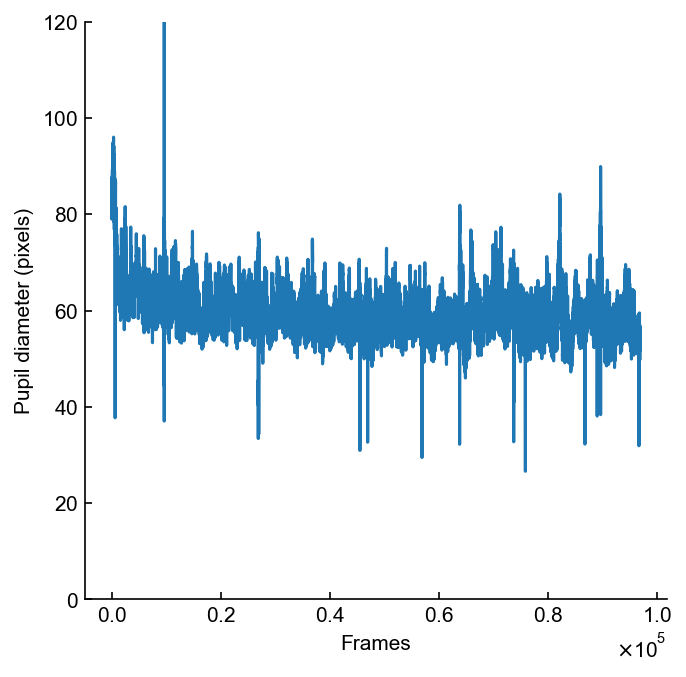

In [16]:
pupildiameter1 = cal_pupildiameter(dataframe1,dataskeleton1)

fig,ax = plt.subplots(figsize=(5,5))
ax.plot(pupildiameter1)
ax.set_ylabel('Pupil diameter (pixels)')
ax.set_xlabel('Frames')

ax.set_ylim([0,120])

#ax.set_xlim([0,2075])
#ax.set_xticks([0,500,1000,1500,2075])
#ax.set_xticklabels(['0','500','1000','1500','2075'])
#fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion project training\\308_2024-04-26_11-40-26\\analysis pupil.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')

print(len(pupildiameter1))

meta NOT subset; don't know how to subset; dropped


96948


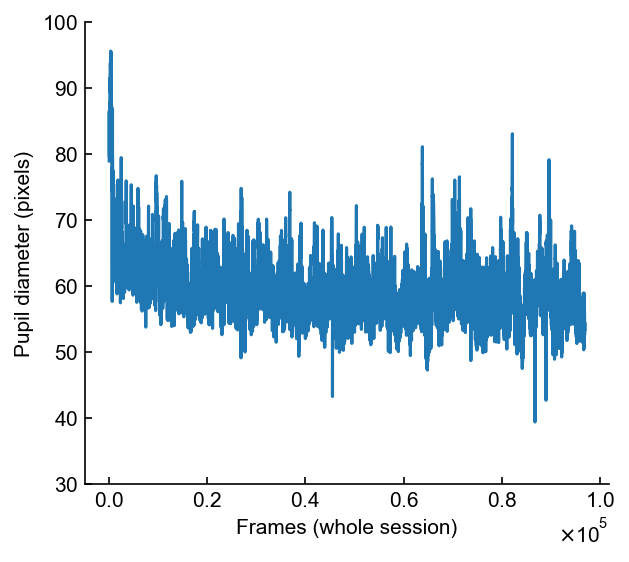

In [317]:
pupildiameter1 = cal_pupildiameter(dataframe1,dataskeleton1)

import scipy
pupildiameter_filtered = scipy.signal.medfilt(pupildiameter1,kernel_size=9)

fig,ax = plt.subplots(figsize=(4.5,4))
ax.plot(pupildiameter_filtered)
ax.set_ylabel('Pupil diameter (pixels)')
ax.set_xlabel('Frames (whole session)')

ax.set_ylim([30,100])

#ax.set_xlim([0,2075])
#ax.set_xticks([0,500,1000,1500,2075])
#ax.set_xticklabels(['0','500','1000','1500','2075'])
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion project training\\308_2024-04-26_11-40-26\\session pupil diamters_filtered.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')

print(len(pupildiameter_filtered))

# get behavior data

In [318]:
from scipy import io
behavior = io.loadmat('C:\\Users\insan\\Desktop\\Motion project training\\308_2024-04-26_11-40-26\\behavior.mat')

In [121]:
behavior

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu May  2 15:40:28 2024',
 '__version__': '1.0',
 '__globals__': [],
 'a': array([[  4],
        [128],
        [128],
        ...,
        [128],
        [128],
        [128]], dtype=uint16),
 'ans': array([[0, 0, 0, ..., 1, 1, 1]], dtype=uint8),
 'b': array([[     482,      543,     1557, ..., 98309438, 98310452, 98311466]],
       dtype=uint32),
 'binSizeSeconds': array([[0.1]]),
 'binarizedSpeakerData': array([[0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'dlc_data_file_name': array(['308_2024-04-26_11-40-26DLC_resnet50_Training_projectApr9shuffle1_500000_skeleton.csv'],
       dtype='<U84'),
 'dlc_data_file_path': array(['G:\\My Drive\\InsanallyLabNotebook-Tal\\Code\\Repo\\Animals\\308\\308_2024-04-26_11-40-26\\'],
       dtype='<U83'),
 'None': MatlabOpaque([(b'trial_data_table', b'MCOS', b'table', array([[3707764736],
                      [         2],
                      [         1],
                      [   

In [63]:
import pandas as pd
data = pd.read_csv('C:\\Users\insan\\Desktop\\Motion project training\\308_2024-04-26_11-40-26\\308_session_TrainingStage_4_04-26_11_47_28.csv')
data.head()

,Trial,Difficulty,Choice,Corr. Choice,Trial Start (master),Tone Start Time,Trial Duration,RT,ITI,Stim Dur.,LicksL,LicksR,LicksITI
0,1,-0.6,L,L,0.014310,0.007850,1.038481,0.300731,2.506560,1.000290,114,22,125
1,2,1.0,L,R,52.750951,0.002254,1.013785,0.110380,2.477598,1.000271,129,38,22
2,3,0.6,R,R,64.334399,0.002163,1.012949,0.076323,2.408395,1.000266,164,54,40
3,4,-1.0,L,L,80.569722,0.002154,1.011326,0.212903,2.155959,1.000278,222,55,50
4,5,-0.6,L,L,96.686855,0.004428,1.019661,0.162312,2.964617,1.000613,259,60,30


In [319]:
trial_starts = behavior['trial_start_timestamps'][0] #samples
tone_starts = np.array(data.iloc[:,5]) #seconds
tone_starts = tone_starts*30000 + trial_starts #samples

video_frames = behavior['frames_timestamps'][0] #samples
trial_difficulty = data.iloc[:,1]
trial_difficulty = np.array(trial_difficulty)
trial_choice = data.iloc[:,2]
trial_correct_choice = data.iloc[:,3]

frame_rate_samples = 30/30000 #samples #frame rate = 30/s
trial_length_to_check_samples = int((0.1+1.05+1.05)*30000) #samples
trial_length_to_check_frames = int(trial_length_to_check_samples*frame_rate_samples)

In [320]:
print(trial_length_to_check_samples)
print(trial_length_to_check_frames) #66 frames = 2.2s

66000
66


In [321]:
type(trial_starts)

numpy.ndarray

In [322]:
print(len(video_frames))
print(len(trial_starts))
print(len(trial_difficulty))
print(len(tone_starts))
print(len(pupildiameter1))
print(np.unique(trial_difficulty))
#print(trial_length_to_check)

96953
426
426
426
96948
[-1.  -0.6 -0.3  0.   0.3  0.6  1. ]


In [323]:
correct_trials = np.where(trial_choice == trial_correct_choice)[0]
incorrect_trials =  np.where(trial_choice != trial_correct_choice)[0]
print(len(correct_trials))
print(len(incorrect_trials))

255
171


In [324]:
L3_trials = np.where(trial_difficulty == -1)[0] #low
L2_trials = np.where(trial_difficulty == -0.6)[0]
L1_trials = np.where(trial_difficulty == -0.3)[0]
#hard_trials = np.where(trial_difficulty == 0)[0]
R1_trials = np.where(trial_difficulty == 0.3)[0] #high
R2_trials = np.where(trial_difficulty == 0.6)[0]
R3_trials = np.where(trial_difficulty == 1)[0]

L3_trial_starts = trial_starts[L3_trials]
L2_trial_starts = trial_starts[L2_trials]
L1_trial_starts = trial_starts[L1_trials]
#hard_trial_starts = trial_starts[hard_trials]
R1_trial_starts = trial_starts[R1_trials]
R2_trial_starts = trial_starts[R2_trials]
R3_trial_starts = trial_starts[R3_trials]

L3_tone_starts = tone_starts[L3_trials]
L2_tone_starts = tone_starts[L2_trials]
L1_tone_starts = tone_starts[L1_trials]
#hard_trial_starts = tone_starts[hard_trials]
R1_tone_starts = tone_starts[R1_trials]
R2_tone_starts = tone_starts[R2_trials]
R3_tone_starts = tone_starts[R3_trials]

print(len(L3_trial_starts))
print(len(L2_trial_starts))
print(len(L1_trial_starts))
#print(len(hard_trial_starts))
print(len(R3_trial_starts))
print(len(R2_trial_starts))
print(len(R1_trial_starts))

52
33
37
100
69
69


In [301]:
L3_correct_trials = np.intersect1d(L3_trials,correct_trials)
L2_correct_trials = np.intersect1d(L2_trials,correct_trials)
L1_correct_trials = np.intersect1d(L1_trials,correct_trials)

R1_correct_trials = np.intersect1d(R1_trials,correct_trials)
R2_correct_trials = np.intersect1d(R2_trials,correct_trials)
R3_correct_trials = np.intersect1d(R3_trials,correct_trials)

L3_incorrect_trials = np.intersect1d(L3_trials,incorrect_trials)
L2_incorrect_trials = np.intersect1d(L2_trials,incorrect_trials)
L1_incorrect_trials = np.intersect1d(L1_trials,incorrect_trials)

R1_incorrect_trials = np.intersect1d(R1_trials,incorrect_trials)
R2_incorrect_trials = np.intersect1d(R2_trials,incorrect_trials)
R3_incorrect_trials = np.intersect1d(R3_trials,incorrect_trials)

In [303]:
L3_correct_trials_per = len(L3_correct_trials)/len(L3_trials)*100
L2_correct_trials_per = len(L2_correct_trials)/len(L2_trials)*100
L1_correct_trials_per = len(L1_correct_trials)/len(L1_trials)*100

R1_correct_trials_per = len(R1_correct_trials)/len(R1_trials)*100
R2_correct_trials_per = len(R2_correct_trials)/len(R2_trials)*100
R3_correct_trials_per = len(R3_correct_trials)/len(R3_trials)*100

In [305]:
L3_incorrect_trials_per = len(L3_incorrect_trials)/len(L3_trials)*100
L2_incorrect_trials_per = len(L2_incorrect_trials)/len(L2_trials)*100
L1_incorrect_trials_per = len(L1_incorrect_trials)/len(L1_trials)*100

R1_incorrect_trials_per = len(R1_incorrect_trials)/len(R1_trials)*100
R2_incorrect_trials_per = len(R2_incorrect_trials)/len(R2_trials)*100
R3_incorrect_trials_per = len(R3_incorrect_trials)/len(R3_trials)*100

In [296]:
print(len(L3_correct_trials))
print(len(L2_correct_trials))
print(len(L1_correct_trials))
print(len(R1_correct_trials))
print(len(R2_correct_trials))
print(len(R3_correct_trials))

47
28
27
31
30
69


In [297]:
print(len(L3_incorrect_trials))
print(len(L2_incorrect_trials))
print(len(L1_incorrect_trials))
print(len(R1_incorrect_trials))
print(len(R2_incorrect_trials))
print(len(R3_incorrect_trials))

5
5
10
38
39
31


In [300]:
print(len(L3_trial_starts))
print(len(L2_trial_starts))
print(len(L1_trial_starts))
print(len(R1_trial_starts))
print(len(R2_trial_starts))
print(len(R3_trial_starts))

52
33
37
69
69
100


[90.38461538461539, 84.84848484848484, 72.97297297297297, 69.0, 43.47826086956522, 44.927536231884055]
[9.615384615384617, 15.151515151515152, 27.027027027027028, 31.0, 56.52173913043478, 55.072463768115945]


meta NOT subset; don't know how to subset; dropped


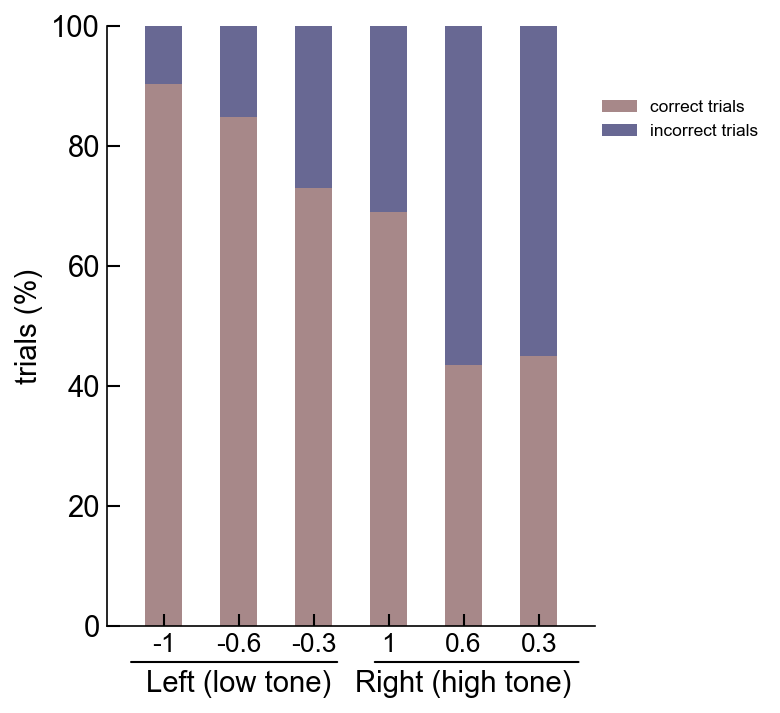

In [345]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0
################################################################################################################

#Plot figure
labels = ['-1','-0.6','-0.3','1','0.6','0.3']

correct = [L3_correct_trials_per,L2_correct_trials_per,L1_correct_trials_per,R3_correct_trials_per,R2_correct_trials_per,R1_correct_trials_per]
incorrect = [L3_incorrect_trials_per,L2_incorrect_trials_per,L1_incorrect_trials_per,R3_incorrect_trials_per,R2_incorrect_trials_per,R1_incorrect_trials_per]
print(correct)
print(incorrect)

ax.bar(range(len(labels)),correct,label = 'correct trials',width = 0.5, color='#A78889')
ax.bar(range(len(labels)),incorrect, bottom = correct, label = 'incorrect trials',width = 0.5,  color='#686893')



################################################################################################################


ax.set_ylim([0,100])
ax.set_yticks([0,20,40,60,80,100])
ax.set_yticklabels(['0','20','40','60','80','100'])
ylab = ax.set_ylabel('trials (%)')
ax.legend(frameon=False,loc=(1,0.8))

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Left (low tone)', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Right (high tone)', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Linear
# Y = np.mean(ax.get_ylim())
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion project training\\308_2024-04-26_11-40-26\\trial correct percentage based on difficulties.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')


In [271]:
np.intersect1d(L3_trials,correct_trials)

array([  3,   8,  28,  54,  67,  82,  94, 111, 113, 121, 122, 124, 125,
       146, 147, 162, 165, 188, 195, 197, 198, 203, 216, 220, 221, 240,
       242, 243, 248, 253, 260, 280, 281, 283, 299, 303, 311, 323, 369,
       370, 381, 384, 395, 401, 404, 407, 417], dtype=int64)

In [272]:
np.intersect1d(L3_trials,incorrect_trials)

array([ 98, 120, 364, 374, 420], dtype=int64)

In [274]:
len(L3_trials)

52

In [275]:
incorrect_trials

array([  1,   6,   7,  10,  12,  14,  15,  17,  19,  20,  22,  26,  27,
        29,  30,  31,  32,  33,  34,  35,  36,  38,  41,  47,  50,  52,
        57,  60,  61,  64,  68,  71,  74,  75,  83,  86,  87,  88,  89,
        93,  96,  98, 103, 107, 114, 117, 120, 123, 126, 132, 134, 135,
       137, 138, 140, 148, 150, 151, 155, 159, 161, 164, 167, 168, 169,
       171, 173, 174, 175, 177, 179, 182, 184, 186, 187, 190, 191, 194,
       199, 200, 201, 202, 206, 217, 222, 223, 227, 233, 234, 236, 238,
       244, 245, 249, 250, 251, 252, 254, 257, 258, 259, 261, 262, 263,
       264, 265, 266, 267, 268, 269, 271, 276, 277, 278, 282, 284, 285,
       287, 288, 290, 291, 296, 297, 304, 312, 319, 320, 321, 325, 326,
       327, 331, 332, 335, 336, 339, 343, 347, 350, 351, 354, 359, 360,
       362, 363, 364, 371, 372, 374, 378, 379, 383, 388, 390, 391, 393,
       396, 399, 400, 403, 408, 409, 411, 412, 418, 419, 420, 422, 423,
       424, 425], dtype=int64)

In [276]:
def find_difficulty_pupildiameters(trials): 
    level_trial_starts = tone_starts[trials]
    level_trial_starts = level_trial_starts[:-1]
    level_trial_start_frames = np.ceil(level_trial_starts * frame_rate_samples)
    level_trial_start_frames = level_trial_start_frames
    level_trial_end_frames = level_trial_start_frames + trial_length_to_check_frames
    level_trial_start_frames = level_trial_start_frames.astype(int)
    level_trial_end_frames = level_trial_end_frames.astype(int)
    level_trials_pupildiameters = np.zeros([len(level_trial_starts),trial_length_to_check_frames])
    
    for trial, pupildiameters in enumerate(level_trials_pupildiameters):
        #print(level_trials_pupildiameters.shape)
        #print(pupildiameter1[level_trial_start_frames[trial]:level_trial_end_frames[trial]].shape)
        level_trials_pupildiameters[trial] =  pupildiameter_filtered[level_trial_start_frames[trial]:level_trial_end_frames[trial]]
        #print(pupildiameters)
    
    return level_trials_pupildiameters

In [277]:
L3_trials_pupildiameters.shape

(46, 66)

In [278]:
L3_trials_pupildiameters

array([[72.78961931, 72.78961931, 72.78961931, ..., 72.84696074,
        72.7462269 , 72.7332076 ],
       [65.74123302, 65.74917228, 65.84980785, ..., 63.72542942,
        63.72542942, 63.72542942],
       [60.22922582, 60.64380885, 60.65551843, ..., 70.54756193,
        70.74469706, 70.74469706],
       ...,
       [61.92536753, 60.97887607, 60.89238009, ..., 60.92250552,
        60.86959811, 60.82569537],
       [58.3832647 , 58.59098796, 58.59098796, ..., 60.70245296,
        61.25011315, 61.67287614],
       [65.08014818, 65.04234301, 64.87228184, ..., 57.64333348,
        57.64333348, 57.63629859]])

In [279]:
len(np.mean(L3_trials_pupildiameters,axis=0))

66

# tone start pupil diameters correct trials

In [346]:
L3_trials_pupildiameters = find_difficulty_pupildiameters(L3_correct_trials)
L2_trials_pupildiameters = find_difficulty_pupildiameters(L2_correct_trials)
L1_trials_pupildiameters = find_difficulty_pupildiameters(L1_correct_trials)
R1_trials_pupildiameters = find_difficulty_pupildiameters(R1_correct_trials)
R2_trials_pupildiameters = find_difficulty_pupildiameters(R2_correct_trials)
R3_trials_pupildiameters = find_difficulty_pupildiameters(R3_correct_trials)

In [347]:
mean_L3_trials_pupildiameters = np.mean(L3_trials_pupildiameters,axis=0)
mean_L2_trials_pupildiameters = np.mean(L2_trials_pupildiameters,axis=0)
mean_L1_trials_pupildiameters = np.mean(L1_trials_pupildiameters,axis=0)
mean_R1_trials_pupildiameters = np.mean(R1_trials_pupildiameters,axis=0)
mean_R2_trials_pupildiameters = np.mean(R2_trials_pupildiameters,axis=0)
mean_R3_trials_pupildiameters = np.mean(R3_trials_pupildiameters,axis=0)

sem_L3_trials_pupildiameters = sem(L3_trials_pupildiameters,axis=0)
sem_L2_trials_pupildiameters = sem(L2_trials_pupildiameters,axis=0)
sem_L1_trials_pupildiameters = sem(L1_trials_pupildiameters,axis=0)
sem_R1_trials_pupildiameters = sem(R1_trials_pupildiameters,axis=0)
sem_R2_trials_pupildiameters = sem(R2_trials_pupildiameters,axis=0)
sem_R3_trials_pupildiameters = sem(R3_trials_pupildiameters,axis=0)

meta NOT subset; don't know how to subset; dropped


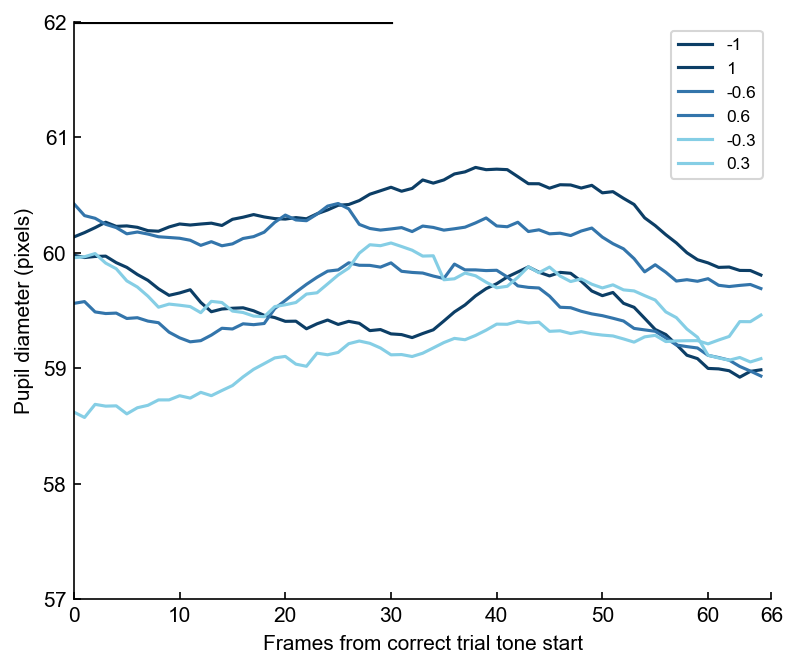

In [348]:
fig,ax = plt.subplots(figsize=(6,5))

ax.plot(mean_L3_trials_pupildiameters,label = '-1',color = '#0c3e66')
ax.plot(mean_R3_trials_pupildiameters,label = '1', color = '#0c3e66')
ax.plot(mean_L2_trials_pupildiameters,label = '-0.6',color = '#3375ab')
ax.plot(mean_R2_trials_pupildiameters,label = '0.6',color='#3375ab')
ax.plot(mean_L1_trials_pupildiameters,label = '-0.3',color = '#85cee5')
ax.plot(mean_R1_trials_pupildiameters,label = '0.3',color='#85cee5')



#ax.fill_between(np.arange(0,66),mean_R3_trials_pupildiameters-sem_R3_trials_pupildiameters,mean_R3_trials_pupildiameters+sem_R3_trials_pupildiameters,color='black',alpha=0.5,zorder=-10,lw=0)


ax.plot([0,30],[62,62],color='k',lw=2,linestyle='-') #tone duration

ax.set_ylabel('Pupil diameter (pixels)')
ax.set_xlabel('Frames from correct trial tone start')

ax.set_ylim([57,62])

ax.set_xlim([0,66])
ax.legend()
ax.set_xticks([0,10,20,30,40,50,60,66])
ax.set_xticklabels(['0','10','20','30','40','50','60','66'])

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion project training\\308_2024-04-26_11-40-26\\correct trial pupil diameters.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')


In [349]:
import scipy
print(scipy.stats.mannwhitneyu(mean_L3_trials_pupildiameters,mean_R3_trials_pupildiameters))
print(scipy.stats.mannwhitneyu(mean_L3_trials_pupildiameters,mean_L2_trials_pupildiameters))
print(scipy.stats.mannwhitneyu(mean_L3_trials_pupildiameters,mean_L1_trials_pupildiameters))

MannwhitneyuResult(statistic=48.0, pvalue=3.271428259484644e-22)
MannwhitneyuResult(statistic=169.0, pvalue=6.188958516661799e-20)
MannwhitneyuResult(statistic=3797.0, pvalue=1.7578232585502035e-13)


meta NOT subset; don't know how to subset; dropped


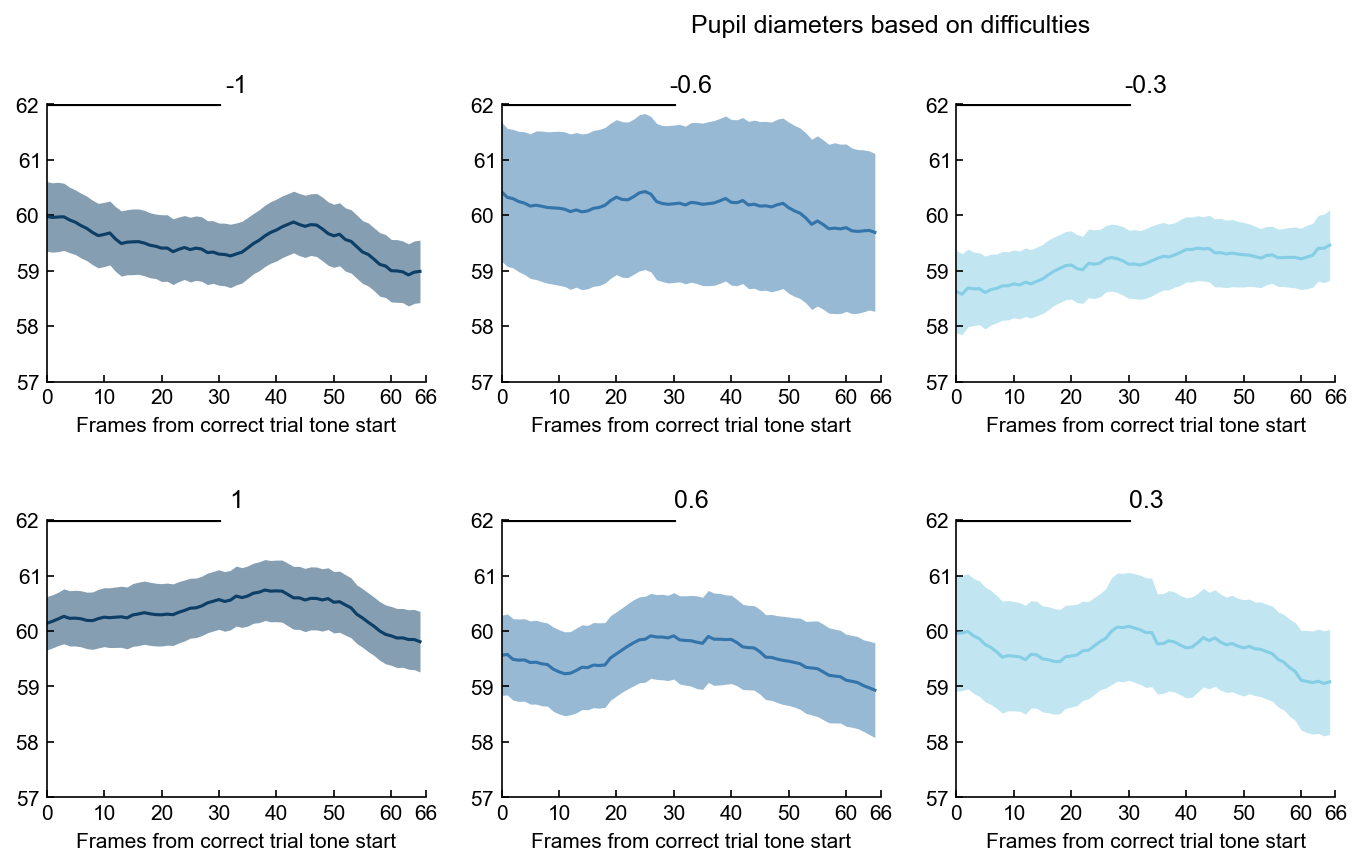

In [350]:
fig = plt.figure(figsize=(15,6))
gs = fig.add_gridspec(2,4,height_ratios=[1,1],hspace=0.5)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1],sharex = ax1,sharey = ax1)
ax3 = plt.subplot(gs[0,2],sharex = ax1,sharey = ax1)
ax4 = plt.subplot(gs[1,0],sharex = ax1,sharey = ax1)
ax5 = plt.subplot(gs[1,1],sharex = ax1,sharey = ax1)
ax6 = plt.subplot(gs[1,2],sharex = ax1,sharey = ax1)


ax1.set_ylim([57,62])
ax1.set_xlim([0,66])
ax1.set_xticks([0,10,20,30,40,50,60,66])
ax1.set_xticklabels(['0','10','20','30','40','50','60','66'])

ax1.set_xlabel('Frames from correct trial tone start')
ax2.set_xlabel('Frames from correct trial tone start')
ax3.set_xlabel('Frames from correct trial tone start')
ax4.set_xlabel('Frames from correct trial tone start')
ax5.set_xlabel('Frames from correct trial tone start')
ax6.set_xlabel('Frames from correct trial tone start')

ax1.plot(mean_L3_trials_pupildiameters,label = '-1',color = '#0c3e66')
ax1.fill_between(np.arange(0,66),mean_L3_trials_pupildiameters-sem_L3_trials_pupildiameters,mean_L3_trials_pupildiameters+sem_L3_trials_pupildiameters,color='#0c3e66',alpha=0.5,zorder=-10,lw=0)

ax2.plot(mean_L2_trials_pupildiameters,label = '-0.6',color = '#3375ab')
ax2.fill_between(np.arange(0,66),mean_L2_trials_pupildiameters-sem_L2_trials_pupildiameters,mean_L2_trials_pupildiameters+sem_L2_trials_pupildiameters,color='#3375ab',alpha=0.5,zorder=-10,lw=0)

ax3.plot(mean_L1_trials_pupildiameters,label = '-0.3',color = '#85cee5')
ax3.fill_between(np.arange(0,66),mean_L1_trials_pupildiameters-sem_L1_trials_pupildiameters,mean_L1_trials_pupildiameters+sem_L1_trials_pupildiameters,color='#85cee5',alpha=0.5,zorder=-10,lw=0)

ax4.plot(mean_R3_trials_pupildiameters,label = '1', color = '#0c3e66')
ax4.fill_between(np.arange(0,66),mean_R3_trials_pupildiameters-sem_R3_trials_pupildiameters,mean_R3_trials_pupildiameters+sem_R3_trials_pupildiameters,color='#0c3e66',alpha=0.5,zorder=-10,lw=0)

ax5.plot(mean_R2_trials_pupildiameters,label = '0.6',color='#3375ab')
ax5.fill_between(np.arange(0,66),mean_R2_trials_pupildiameters-sem_R2_trials_pupildiameters,mean_R2_trials_pupildiameters+sem_R2_trials_pupildiameters,color='#3375ab',alpha=0.5,zorder=-10,lw=0)

ax6.plot(mean_R1_trials_pupildiameters,label = '0.3',color='#85cee5')
ax6.fill_between(np.arange(0,66),mean_R1_trials_pupildiameters-sem_R1_trials_pupildiameters,mean_R1_trials_pupildiameters+sem_R1_trials_pupildiameters,color='#85cee5',alpha=0.5,zorder=-10,lw=0)



ax1.set_title('-1')
ax2.set_title('-0.6')
ax3.set_title('-0.3')
ax4.set_title('1')
ax5.set_title('0.6')
ax6.set_title('0.3')
plt.suptitle('Pupil diameters based on difficulties')

ax1.plot([0,30],[62,62],color='k',lw=2,linestyle='-') #tone duration
ax2.plot([0,30],[62,62],color='k',lw=2,linestyle='-') #tone duration
ax3.plot([0,30],[62,62],color='k',lw=2,linestyle='-') #tone duration
ax4.plot([0,30],[62,62],color='k',lw=2,linestyle='-') #tone duration
ax5.plot([0,30],[62,62],color='k',lw=2,linestyle='-') #tone duration
ax6.plot([0,30],[62,62],color='k',lw=2,linestyle='-') #tone duration

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion project training\\308_2024-04-26_11-40-26\\Pupil diameters based on difficulties correct trials.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')


# tone start pupil diameters incorrect trials

In [351]:
L3_trials_pupildiameters = find_difficulty_pupildiameters(L3_incorrect_trials)
L2_trials_pupildiameters = find_difficulty_pupildiameters(L2_incorrect_trials)
L1_trials_pupildiameters = find_difficulty_pupildiameters(L1_incorrect_trials)
R1_trials_pupildiameters = find_difficulty_pupildiameters(R1_incorrect_trials)
R2_trials_pupildiameters = find_difficulty_pupildiameters(R2_incorrect_trials)
R3_trials_pupildiameters = find_difficulty_pupildiameters(R3_incorrect_trials)

In [352]:
mean_L3_trials_pupildiameters = np.mean(L3_trials_pupildiameters,axis=0)
mean_L2_trials_pupildiameters = np.mean(L2_trials_pupildiameters,axis=0)
mean_L1_trials_pupildiameters = np.mean(L1_trials_pupildiameters,axis=0)
mean_R1_trials_pupildiameters = np.mean(R1_trials_pupildiameters,axis=0)
mean_R2_trials_pupildiameters = np.mean(R2_trials_pupildiameters,axis=0)
mean_R3_trials_pupildiameters = np.mean(R3_trials_pupildiameters,axis=0)

sem_L3_trials_pupildiameters = sem(L3_trials_pupildiameters,axis=0)
sem_L2_trials_pupildiameters = sem(L2_trials_pupildiameters,axis=0)
sem_L1_trials_pupildiameters = sem(L1_trials_pupildiameters,axis=0)
sem_R1_trials_pupildiameters = sem(R1_trials_pupildiameters,axis=0)
sem_R2_trials_pupildiameters = sem(R2_trials_pupildiameters,axis=0)
sem_R3_trials_pupildiameters = sem(R3_trials_pupildiameters,axis=0)

meta NOT subset; don't know how to subset; dropped


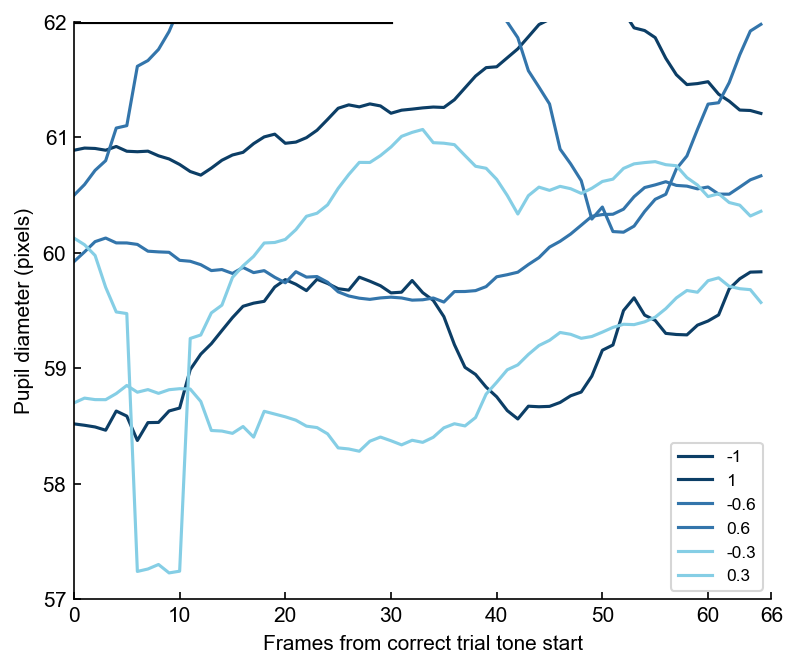

In [353]:
fig,ax = plt.subplots(figsize=(6,5))

ax.plot(mean_L3_trials_pupildiameters,label = '-1',color = '#0c3e66')
ax.plot(mean_R3_trials_pupildiameters,label = '1', color = '#0c3e66')
ax.plot(mean_L2_trials_pupildiameters,label = '-0.6',color = '#3375ab')
ax.plot(mean_R2_trials_pupildiameters,label = '0.6',color='#3375ab')
ax.plot(mean_L1_trials_pupildiameters,label = '-0.3',color = '#85cee5')
ax.plot(mean_R1_trials_pupildiameters,label = '0.3',color='#85cee5')



#ax.fill_between(np.arange(0,66),mean_R3_trials_pupildiameters-sem_R3_trials_pupildiameters,mean_R3_trials_pupildiameters+sem_R3_trials_pupildiameters,color='black',alpha=0.5,zorder=-10,lw=0)


ax.plot([0,30],[62,62],color='k',lw=2,linestyle='-') #tone duration

ax.set_ylabel('Pupil diameter (pixels)')
ax.set_xlabel('Frames from correct trial tone start')

ax.set_ylim([57,62])

ax.set_xlim([0,66])
ax.legend()
ax.set_xticks([0,10,20,30,40,50,60,66])
ax.set_xticklabels(['0','10','20','30','40','50','60','66'])

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion project training\\308_2024-04-26_11-40-26\\incorrect trial pupil diameters.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')


meta NOT subset; don't know how to subset; dropped


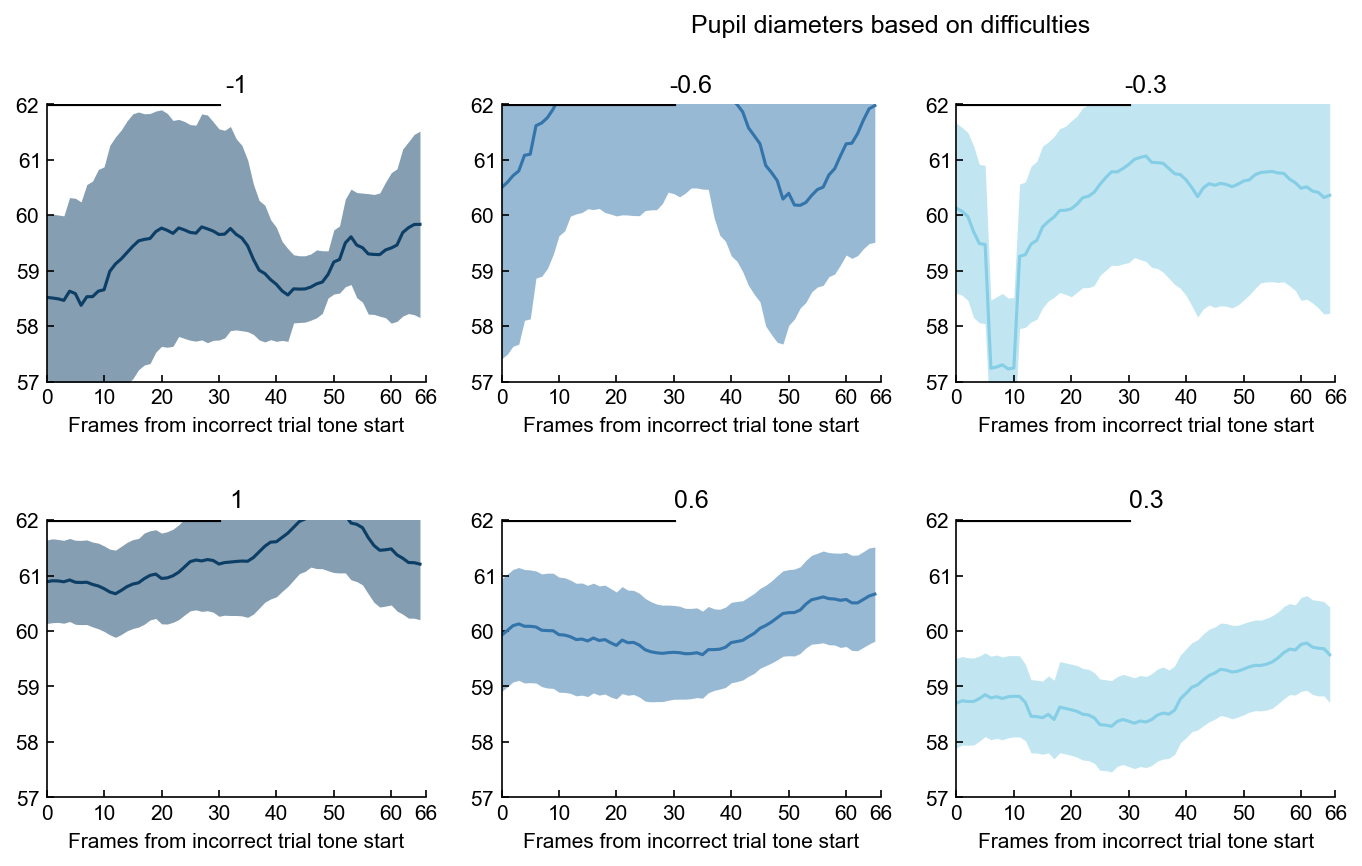

In [354]:
fig = plt.figure(figsize=(15,6))
gs = fig.add_gridspec(2,4,height_ratios=[1,1],hspace=0.5)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1],sharex = ax1,sharey = ax1)
ax3 = plt.subplot(gs[0,2],sharex = ax1,sharey = ax1)
ax4 = plt.subplot(gs[1,0],sharex = ax1,sharey = ax1)
ax5 = plt.subplot(gs[1,1],sharex = ax1,sharey = ax1)
ax6 = plt.subplot(gs[1,2],sharex = ax1,sharey = ax1)


ax1.set_ylim([57,62])
ax1.set_xlim([0,66])
ax1.set_xticks([0,10,20,30,40,50,60,66])
ax1.set_xticklabels(['0','10','20','30','40','50','60','66'])

ax1.set_xlabel('Frames from incorrect trial tone start')
ax2.set_xlabel('Frames from incorrect trial tone start')
ax3.set_xlabel('Frames from incorrect trial tone start')
ax4.set_xlabel('Frames from incorrect trial tone start')
ax5.set_xlabel('Frames from incorrect trial tone start')
ax6.set_xlabel('Frames from incorrect trial tone start')

ax1.plot(mean_L3_trials_pupildiameters,label = '-1',color = '#0c3e66')
ax1.fill_between(np.arange(0,66),mean_L3_trials_pupildiameters-sem_L3_trials_pupildiameters,mean_L3_trials_pupildiameters+sem_L3_trials_pupildiameters,color='#0c3e66',alpha=0.5,zorder=-10,lw=0)

ax2.plot(mean_L2_trials_pupildiameters,label = '-0.6',color = '#3375ab')
ax2.fill_between(np.arange(0,66),mean_L2_trials_pupildiameters-sem_L2_trials_pupildiameters,mean_L2_trials_pupildiameters+sem_L2_trials_pupildiameters,color='#3375ab',alpha=0.5,zorder=-10,lw=0)

ax3.plot(mean_L1_trials_pupildiameters,label = '-0.3',color = '#85cee5')
ax3.fill_between(np.arange(0,66),mean_L1_trials_pupildiameters-sem_L1_trials_pupildiameters,mean_L1_trials_pupildiameters+sem_L1_trials_pupildiameters,color='#85cee5',alpha=0.5,zorder=-10,lw=0)

ax4.plot(mean_R3_trials_pupildiameters,label = '1', color = '#0c3e66')
ax4.fill_between(np.arange(0,66),mean_R3_trials_pupildiameters-sem_R3_trials_pupildiameters,mean_R3_trials_pupildiameters+sem_R3_trials_pupildiameters,color='#0c3e66',alpha=0.5,zorder=-10,lw=0)

ax5.plot(mean_R2_trials_pupildiameters,label = '0.6',color='#3375ab')
ax5.fill_between(np.arange(0,66),mean_R2_trials_pupildiameters-sem_R2_trials_pupildiameters,mean_R2_trials_pupildiameters+sem_R2_trials_pupildiameters,color='#3375ab',alpha=0.5,zorder=-10,lw=0)

ax6.plot(mean_R1_trials_pupildiameters,label = '0.3',color='#85cee5')
ax6.fill_between(np.arange(0,66),mean_R1_trials_pupildiameters-sem_R1_trials_pupildiameters,mean_R1_trials_pupildiameters+sem_R1_trials_pupildiameters,color='#85cee5',alpha=0.5,zorder=-10,lw=0)



ax1.set_title('-1')
ax2.set_title('-0.6')
ax3.set_title('-0.3')
ax4.set_title('1')
ax5.set_title('0.6')
ax6.set_title('0.3')
plt.suptitle('Pupil diameters based on difficulties')

ax1.plot([0,30],[62,62],color='k',lw=2,linestyle='-') #tone duration
ax2.plot([0,30],[62,62],color='k',lw=2,linestyle='-') #tone duration
ax3.plot([0,30],[62,62],color='k',lw=2,linestyle='-') #tone duration
ax4.plot([0,30],[62,62],color='k',lw=2,linestyle='-') #tone duration
ax5.plot([0,30],[62,62],color='k',lw=2,linestyle='-') #tone duration
ax6.plot([0,30],[62,62],color='k',lw=2,linestyle='-') #tone duration

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion project training\\308_2024-04-26_11-40-26\\Pupil diameters based on difficulties incorrect trials.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')


# tone start pupil diameters all trials

In [359]:
L3_trials_pupildiameters = find_difficulty_pupildiameters(L3_trials)
L2_trials_pupildiameters = find_difficulty_pupildiameters(L2_trials)
L1_trials_pupildiameters = find_difficulty_pupildiameters(L1_trials)
R1_trials_pupildiameters = find_difficulty_pupildiameters(R1_trials)
R2_trials_pupildiameters = find_difficulty_pupildiameters(R2_trials)
R3_trials_pupildiameters = find_difficulty_pupildiameters(R3_trials)

In [360]:
mean_L3_trials_pupildiameters = np.mean(L3_trials_pupildiameters,axis=0)
mean_L2_trials_pupildiameters = np.mean(L2_trials_pupildiameters,axis=0)
mean_L1_trials_pupildiameters = np.mean(L1_trials_pupildiameters,axis=0)
mean_R1_trials_pupildiameters = np.mean(R1_trials_pupildiameters,axis=0)
mean_R2_trials_pupildiameters = np.mean(R2_trials_pupildiameters,axis=0)
mean_R3_trials_pupildiameters = np.mean(R3_trials_pupildiameters,axis=0)

sem_L3_trials_pupildiameters = sem(L3_trials_pupildiameters,axis=0)
sem_L2_trials_pupildiameters = sem(L2_trials_pupildiameters,axis=0)
sem_L1_trials_pupildiameters = sem(L1_trials_pupildiameters,axis=0)
sem_R1_trials_pupildiameters = sem(R1_trials_pupildiameters,axis=0)
sem_R2_trials_pupildiameters = sem(R2_trials_pupildiameters,axis=0)
sem_R3_trials_pupildiameters = sem(R3_trials_pupildiameters,axis=0)

meta NOT subset; don't know how to subset; dropped


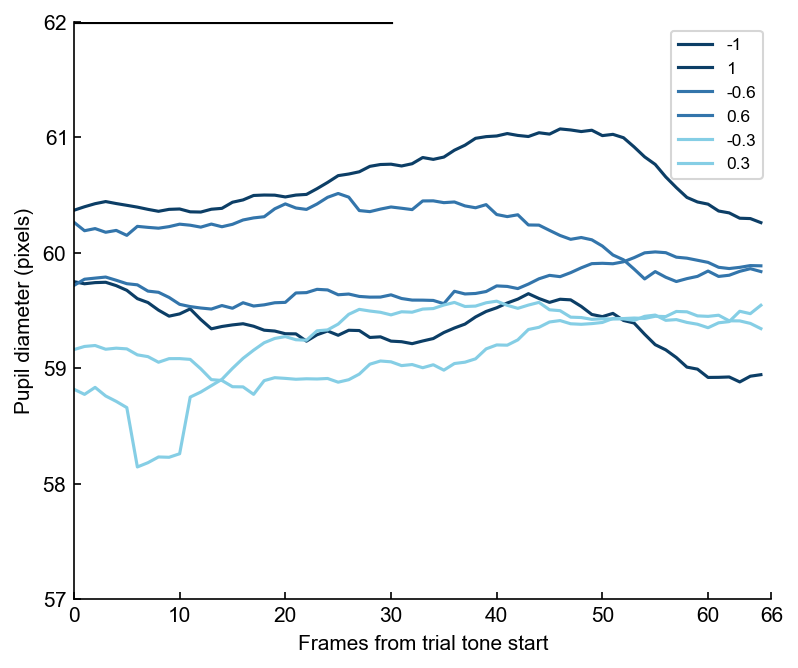

In [361]:
fig,ax = plt.subplots(figsize=(6,5))

ax.plot(mean_L3_trials_pupildiameters,label = '-1',color = '#0c3e66')
ax.plot(mean_R3_trials_pupildiameters,label = '1', color = '#0c3e66')
ax.plot(mean_L2_trials_pupildiameters,label = '-0.6',color = '#3375ab')
ax.plot(mean_R2_trials_pupildiameters,label = '0.6',color='#3375ab')
ax.plot(mean_L1_trials_pupildiameters,label = '-0.3',color = '#85cee5')
ax.plot(mean_R1_trials_pupildiameters,label = '0.3',color='#85cee5')



#ax.fill_between(np.arange(0,66),mean_R3_trials_pupildiameters-sem_R3_trials_pupildiameters,mean_R3_trials_pupildiameters+sem_R3_trials_pupildiameters,color='black',alpha=0.5,zorder=-10,lw=0)


ax.plot([0,30],[62,62],color='k',lw=2,linestyle='-') #tone duration

ax.set_ylabel('Pupil diameter (pixels)')
ax.set_xlabel('Frames from trial tone start')

ax.set_ylim([57,62])

ax.set_xlim([0,66])
ax.legend()
ax.set_xticks([0,10,20,30,40,50,60,66])
ax.set_xticklabels(['0','10','20','30','40','50','60','66'])

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion project training\\308_2024-04-26_11-40-26\\trial pupil diameters.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')


meta NOT subset; don't know how to subset; dropped


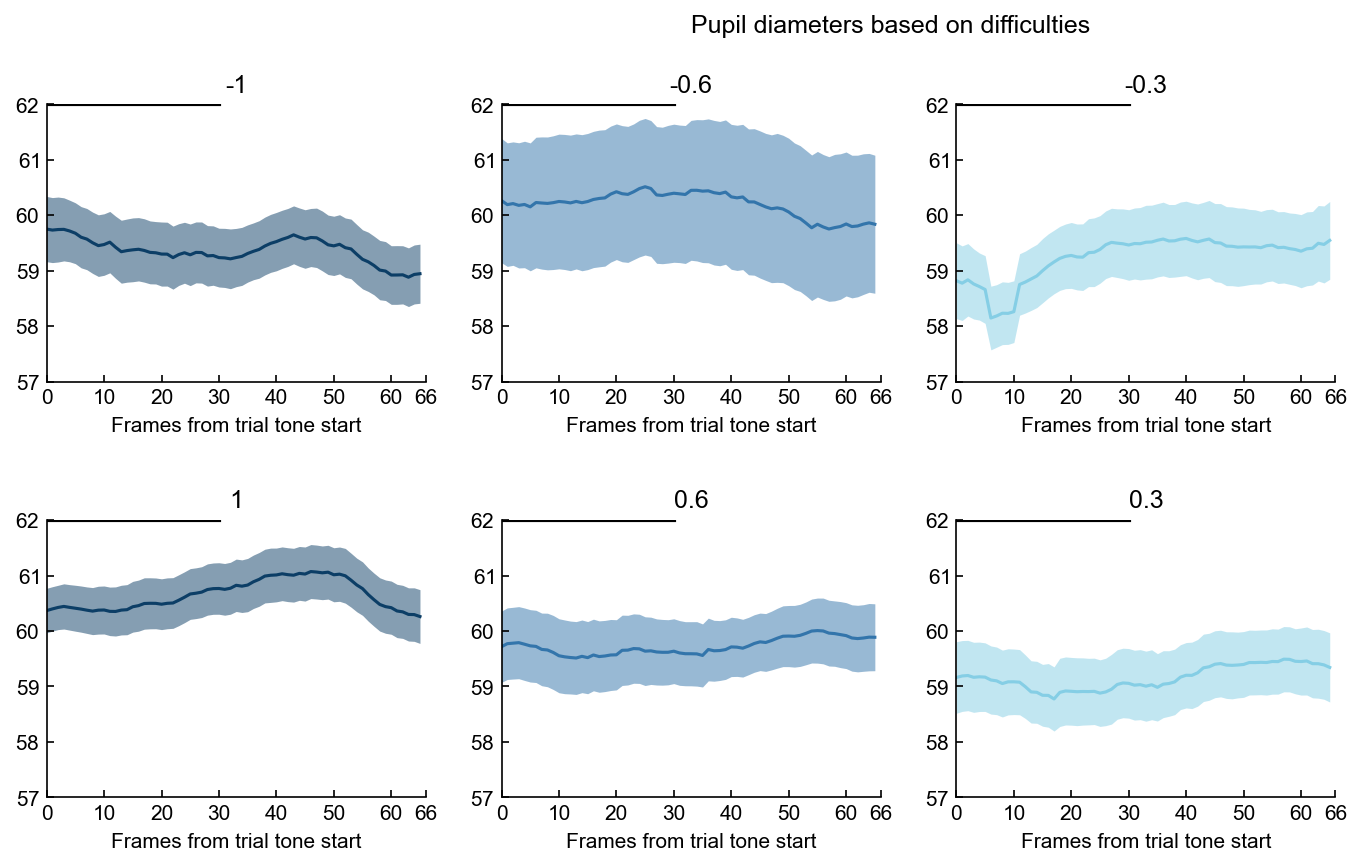

In [362]:
fig = plt.figure(figsize=(15,6))
gs = fig.add_gridspec(2,4,height_ratios=[1,1],hspace=0.5)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1],sharex = ax1,sharey = ax1)
ax3 = plt.subplot(gs[0,2],sharex = ax1,sharey = ax1)
ax4 = plt.subplot(gs[1,0],sharex = ax1,sharey = ax1)
ax5 = plt.subplot(gs[1,1],sharex = ax1,sharey = ax1)
ax6 = plt.subplot(gs[1,2],sharex = ax1,sharey = ax1)


ax1.set_ylim([57,62])
ax1.set_xlim([0,66])
ax1.set_xticks([0,10,20,30,40,50,60,66])
ax1.set_xticklabels(['0','10','20','30','40','50','60','66'])

ax1.set_xlabel('Frames from trial tone start')
ax2.set_xlabel('Frames from trial tone start')
ax3.set_xlabel('Frames from trial tone start')
ax4.set_xlabel('Frames from trial tone start')
ax5.set_xlabel('Frames from trial tone start')
ax6.set_xlabel('Frames from trial tone start')

ax1.plot(mean_L3_trials_pupildiameters,label = '-1',color = '#0c3e66')
ax1.fill_between(np.arange(0,66),mean_L3_trials_pupildiameters-sem_L3_trials_pupildiameters,mean_L3_trials_pupildiameters+sem_L3_trials_pupildiameters,color='#0c3e66',alpha=0.5,zorder=-10,lw=0)

ax2.plot(mean_L2_trials_pupildiameters,label = '-0.6',color = '#3375ab')
ax2.fill_between(np.arange(0,66),mean_L2_trials_pupildiameters-sem_L2_trials_pupildiameters,mean_L2_trials_pupildiameters+sem_L2_trials_pupildiameters,color='#3375ab',alpha=0.5,zorder=-10,lw=0)

ax3.plot(mean_L1_trials_pupildiameters,label = '-0.3',color = '#85cee5')
ax3.fill_between(np.arange(0,66),mean_L1_trials_pupildiameters-sem_L1_trials_pupildiameters,mean_L1_trials_pupildiameters+sem_L1_trials_pupildiameters,color='#85cee5',alpha=0.5,zorder=-10,lw=0)

ax4.plot(mean_R3_trials_pupildiameters,label = '1', color = '#0c3e66')
ax4.fill_between(np.arange(0,66),mean_R3_trials_pupildiameters-sem_R3_trials_pupildiameters,mean_R3_trials_pupildiameters+sem_R3_trials_pupildiameters,color='#0c3e66',alpha=0.5,zorder=-10,lw=0)

ax5.plot(mean_R2_trials_pupildiameters,label = '0.6',color='#3375ab')
ax5.fill_between(np.arange(0,66),mean_R2_trials_pupildiameters-sem_R2_trials_pupildiameters,mean_R2_trials_pupildiameters+sem_R2_trials_pupildiameters,color='#3375ab',alpha=0.5,zorder=-10,lw=0)

ax6.plot(mean_R1_trials_pupildiameters,label = '0.3',color='#85cee5')
ax6.fill_between(np.arange(0,66),mean_R1_trials_pupildiameters-sem_R1_trials_pupildiameters,mean_R1_trials_pupildiameters+sem_R1_trials_pupildiameters,color='#85cee5',alpha=0.5,zorder=-10,lw=0)



ax1.set_title('-1')
ax2.set_title('-0.6')
ax3.set_title('-0.3')
ax4.set_title('1')
ax5.set_title('0.6')
ax6.set_title('0.3')
plt.suptitle('Pupil diameters based on difficulties')

ax1.plot([0,30],[62,62],color='k',lw=2,linestyle='-') #tone duration
ax2.plot([0,30],[62,62],color='k',lw=2,linestyle='-') #tone duration
ax3.plot([0,30],[62,62],color='k',lw=2,linestyle='-') #tone duration
ax4.plot([0,30],[62,62],color='k',lw=2,linestyle='-') #tone duration
ax5.plot([0,30],[62,62],color='k',lw=2,linestyle='-') #tone duration
ax6.plot([0,30],[62,62],color='k',lw=2,linestyle='-') #tone duration

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion project training\\308_2024-04-26_11-40-26\\Pupil diameters based on difficulties.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')


[Text(0, 0, '0'),
 Text(10, 0, '10'),
 Text(20, 0, '20'),
 Text(30, 0, '30'),
 Text(40, 0, '40'),
 Text(50, 0, '50'),
 Text(60, 0, '60'),
 Text(66, 0, '66')]

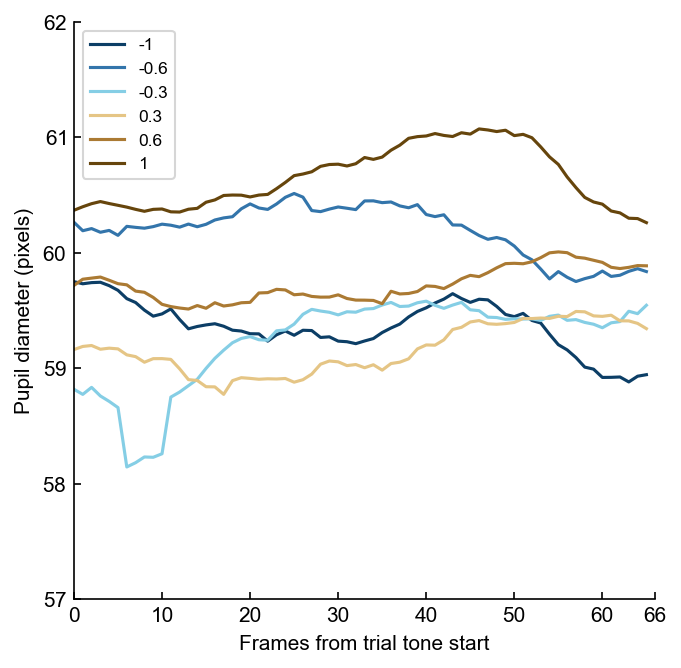

In [343]:
fig,ax = plt.subplots(figsize=(5,5))

ax.plot(np.mean(L3_trials_pupildiameters,axis=0),label = '-1',color = '#0c3e66')
ax.plot(np.mean(L2_trials_pupildiameters,axis=0),label = '-0.6',color = '#3375ab')
ax.plot(np.mean(L1_trials_pupildiameters,axis=0),label = '-0.3',color = '#85cee5')
ax.plot(np.mean(R1_trials_pupildiameters,axis=0),label = '0.3',color='#e5c585')
ax.plot(np.mean(R2_trials_pupildiameters,axis=0),label = '0.6',color='#ab7a33')
ax.plot(np.mean(R3_trials_pupildiameters,axis=0),label = '1', color = '#66450c')

ax.set_ylabel('Pupil diameter (pixels)')
ax.set_xlabel('Frames from trial tone start')

ax.set_ylim([57,62])

ax.set_xlim([0,66])
ax.legend()
ax.set_xticks([0,10,20,30,40,50,60,66])
ax.set_xticklabels(['0','10','20','30','40','50','60','66'])

#fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion project training\\308_2024-04-26_11-40-26\\trial pupil diameters2.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')



# test

In [309]:
L2_trial_start_frames = np.ceil(L2_trial_starts * frame_rate_samples)
L2_trial_end_frames = L2_trial_start_frames + trial_length_to_check_frames
L2_trial_start_frames = L2_trial_start_frames.astype(int)
L2_trial_end_frames = L2_trial_end_frames.astype(int)
L2_trials_pupildiameters = np.zeros([len(L2_trial_starts),trial_length_to_check_frames])
for trial, pupildiameters in enumerate(L2_trials_pupildiameters):
    pupildiameters =  pupildiameter1[L2_trial_start_frames[trial]:L2_trial_end_frames[trial]]

In [329]:
L2_trial_start_frames

array([   87,  2987,  3793,  4285,  4724, 10794, 14462, 16313, 16569,
       19733, 22811, 24680, 26308, 32904, 33798, 36469, 38062, 38726,
       38915, 44517, 48992, 52421, 55507, 58655, 59259, 66124, 66546,
       89504, 90282, 90432, 92963, 96111, 97419])

In [330]:
L2_trial_end_frames

array([  153,  3053,  3859,  4351,  4790, 10860, 14528, 16379, 16635,
       19799, 22877, 24746, 26374, 32970, 33864, 36535, 38128, 38792,
       38981, 44583, 49058, 52487, 55573, 58721, 59325, 66190, 66612,
       89570, 90348, 90498, 93029, 96177, 97485])

In [333]:
L3_trials_pupildiameters = find_difficulty_pupildiameters(L3_trial_starts)

In [334]:
L3_trials_pupildiameters[0]

array([72.31270531, 77.22853254, 72.78961931, 73.02795093, 72.00752948,
       71.8050315 , 71.86548169, 70.80750956, 70.06301321, 69.48431879,
       68.78549617, 68.97266438, 68.00140352, 69.21859094, 69.19195536,
       69.08475976, 68.03424592, 67.59500056, 68.83993482, 69.75064349,
       69.26158027, 69.73462921, 69.41957997, 69.95882808, 70.20561038,
       69.54978392, 69.9944529 , 70.04270563, 70.81353871, 70.20065287,
       70.04093639, 71.0234108 , 70.88436569, 70.55860666, 70.94693523,
       71.40156332, 70.84670656, 70.76954618, 71.66164974, 71.34558988,
       70.65651976, 71.0677646 , 71.45265526, 72.13741074, 71.83828826,
       71.75784259, 75.52542016, 72.22742023, 71.7913947 , 71.77634335,
       72.0222008 , 71.7377543 , 71.3347262 , 71.91285813, 71.82196802,
       72.40610412, 71.81895326, 72.31723649, 77.50201398, 73.90693546,
       72.7462269 , 73.22810177, 72.91048572, 72.57242026, 72.84696074,
       72.93517512])

In [87]:
len(pupildiameter1)

96948

In [88]:
pupildiameter1[]

array([79.42517229, 79.26845094, 79.06959905, ..., 53.76034774,
       53.00334937, 52.84672646])

In [127]:
L2_trial_start_frames = np.ceil(L2_trial_starts * frame_rate_samples)
L2_trial_end_frames = L2_trial_start_frames + trial_length_to_check_frames

L2_trial_start_frames = L2_trial_start_frames.astype(int)
L2_trial_end_frames = L2_trial_end_frames.astype(int)

In [146]:
L2_trial_start_frames

array([   87,  2987,  3793,  4285,  4724, 10794, 14462, 16313, 16569,
       19733, 22811, 24680, 26308, 32904, 33798, 36469, 38062, 38726,
       38915, 44517, 48992, 52421, 55507, 58655, 59259, 66124, 66546,
       89504, 90282, 90432, 92963, 96111, 97419])

In [147]:
L2_trial_end_frames

array([  153,  3053,  3859,  4351,  4790, 10860, 14528, 16379, 16635,
       19799, 22877, 24746, 26374, 32970, 33864, 36535, 38128, 38792,
       38981, 44583, 49058, 52487, 55573, 58721, 59325, 66190, 66612,
       89570, 90348, 90498, 93029, 96177, 97485])

In [233]:
L2_trials_pupildiameters = np.zeros([len(L2_trial_starts),trial_length_to_check_frames])

In [237]:
len(L2_trials_pupildiameters[0])

66

In [ ]:
trial_start

In [258]:
L2_trials_pupildiameters[-1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [255]:
for trial, pupildiameters in enumerate(L2_trials_pupildiameters):
    pupildiameters =  pupildiameter1[L2_trial_start_frames[trial]:L2_trial_end_frames[trial]]

In [254]:
L2_trials_pupildiameters[-2]

array([54.70912568, 55.06120612, 55.78804933, 55.83865426, 56.1672652 ,
       55.9898643 , 56.42250509, 56.49863594, 56.02206457, 55.0914428 ,
       56.01006644, 55.99510734, 56.46254332, 55.81030033, 55.93716349,
       55.69337385, 55.18377417, 55.14161327, 55.57375767, 55.15460422,
       55.73002047, 55.01276531, 54.95925627, 55.21731042, 54.86470286,
       54.80305778, 54.64942004, 55.406411  , 55.65913976, 55.58000012,
       55.56983504, 55.17565872, 55.72659992, 56.06836509, 56.31301895,
       56.08402199, 55.97528743, 55.98670208, 55.90517948, 55.94146383,
       55.94005999, 55.86354379, 55.87437854, 56.43092954, 56.55662907,
       56.64870223, 57.19888191, 56.86902591, 56.70168105, 56.62423908,
       56.42025067, 56.53085681, 56.75615886, 55.73786397, 55.33627403,
       55.40128246, 55.46549041, 55.93911447, 55.78086449, 55.62912683,
       55.85137023, 56.36164851, 56.34539896, 55.91378706, 55.24843445,
       55.32718668])

In [108]:
L2_trial_starts

array([   86852,  2986724,  3792372,  4284022,  4723327, 10793344,
       14461246, 16312405, 16568870, 19732225, 22810243, 24679692,
       26307787, 32903897, 33797344, 36468646, 38061117, 38725661,
       38914638, 44516344, 48991926, 52420185, 55506242, 58654071,
       59258424, 66123600, 66545446, 89503066, 90281030, 90431514,
       92962836, 96110007, 97418913], dtype=uint32)